<a href="https://colab.research.google.com/github/jyesudian/AnoNetworkData/blob/main/cicddos2019/cic_ddos2019_parquet_XGB_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# prompt: Need help in deriving PCA for a dataset. I need sample code. Also, I would like to use the dataset LuFlow which is available in my Google Drive. I think I need to do data engineering on the dataset. Can you give the step by step example and the code accordingly?
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

import seaborn as sns


In [2]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.utils import plot_model
%load_ext tensorboard

In [ ]:
### To check whether GPU is used.
gpu_available = tf.config.list_physical_devices('GPU')

if gpu_available:
    print("GPU is available and being used.")
    print("GPU Details:", gpu_available)
else:
    print("GPU is not available. Using CPU.")

In [4]:
from IPython.display import Image
import os, datetime

In [5]:
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score,confusion_matrix,classification_report,roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

In [6]:
from google.colab import drive
drive.mount('/content/drive')
# Define the file path to your dataset in Google Drive
#file_path = '/content/drive/MyDrive/LuFlow.csv'
#file_path = '/content/drive/MyDrive/VIT/Dataset/CIC-DDos2019/cic-ddos2019.csv'


Mounted at /content/drive


In [7]:
dfps_tr = []
dfps_ts = []
for dirname, _, filenames in os.walk('/content/drive/MyDrive/VIT/Dataset/CIC-DDoS2019/'):
    for filename in filenames:
        if filename.endswith('-training.parquet'):
            dfp = os.path.join(dirname, filename)
            dfps_tr.append(dfp)
            print(dfp)
        elif filename.endswith('-testing.parquet'):
            dfp = os.path.join(dirname, filename)
            dfps_ts.append(dfp)
            print(dfp)

/content/drive/MyDrive/VIT/Dataset/CIC-DDoS2019/DNS-testing.parquet
/content/drive/MyDrive/VIT/Dataset/CIC-DDoS2019/LDAP-testing.parquet
/content/drive/MyDrive/VIT/Dataset/CIC-DDoS2019/MSSQL-testing.parquet
/content/drive/MyDrive/VIT/Dataset/CIC-DDoS2019/MSSQL-training.parquet
/content/drive/MyDrive/VIT/Dataset/CIC-DDoS2019/LDAP-training.parquet
/content/drive/MyDrive/VIT/Dataset/CIC-DDoS2019/SNMP-testing.parquet
/content/drive/MyDrive/VIT/Dataset/CIC-DDoS2019/NTP-testing.parquet
/content/drive/MyDrive/VIT/Dataset/CIC-DDoS2019/UDPLag-testing.parquet
/content/drive/MyDrive/VIT/Dataset/CIC-DDoS2019/UDP-training.parquet
/content/drive/MyDrive/VIT/Dataset/CIC-DDoS2019/Syn-testing.parquet
/content/drive/MyDrive/VIT/Dataset/CIC-DDoS2019/NetBIOS-testing.parquet
/content/drive/MyDrive/VIT/Dataset/CIC-DDoS2019/Portmap-training.parquet
/content/drive/MyDrive/VIT/Dataset/CIC-DDoS2019/UDP-testing.parquet
/content/drive/MyDrive/VIT/Dataset/CIC-DDoS2019/TFTP-testing.parquet
/content/drive/MyDrive/VI

In [8]:
train_df = pd.concat([pd.read_parquet(dfp) for dfp in dfps_tr], ignore_index=True)
test_df = pd.concat([pd.read_parquet(dfp) for dfp in dfps_ts], ignore_index=True)

In [9]:
train_df.shape, test_df.shape

((125170, 78), (306201, 78))

In [10]:
dataframes_to_combine = [train_df, test_df]
# Use pd.concat() to combine the DataFrames row-wise
# The default behavior of concat is to combine along rows (axis=0)
df = pd.concat(dataframes_to_combine, ignore_index=True)

**Store these datasets in Google Drive as they can be used as starting point few use cases.**

In [11]:
def dropInfNull(df):
    print (df.shape)

    # replace infinity value as null value
    df = df.replace(["Infinity", "infinity"], np.inf)
    df = df.replace([np.inf, -np.inf], np.nan)

    # drop all null values
    df.dropna(inplace=True)

    print (df.shape)

    return df

**Now Proceed With Entropies as the Entropy calculation is done by the Luflow dataset providers itself.**

In [12]:
%%time
network_data_d1 = dropInfNull(df)

(431371, 78)
(431371, 78)
CPU times: user 187 ms, sys: 77.2 ms, total: 264 ms
Wall time: 268 ms


In [13]:
#Get the unique labels
unique_labels = network_data_d1['Label'].unique()

#Get the counts of each unique label
label_counts = network_data_d1['Label'].value_counts()

#Print the results

print("Unique Labels:")
print(unique_labels)

print("\nCounts of Each Label:")
print(label_counts)

Unique Labels:
['MSSQL' 'LDAP' 'Benign' 'NetBIOS' 'UDP' 'Portmap' 'Syn' 'UDPLag'
 'DrDoS_DNS' 'DrDoS_LDAP' 'DrDoS_MSSQL' 'DrDoS_SNMP' 'DrDoS_NTP' 'UDP-lag'
 'WebDDoS' 'DrDoS_NetBIOS' 'DrDoS_UDP' 'TFTP']

Counts of Each Label:
Label
DrDoS_NTP        121368
TFTP              98917
Benign            97831
Syn               49373
UDP               18090
DrDoS_UDP         10420
UDP-lag            8872
MSSQL              8523
DrDoS_MSSQL        6212
DrDoS_DNS          3669
DrDoS_SNMP         2717
LDAP               1906
DrDoS_LDAP         1440
Portmap             685
NetBIOS             644
DrDoS_NetBIOS       598
UDPLag               55
WebDDoS              51
Name: count, dtype: int64


In this dataset we have got 97K benign dataset and the huge number of malign dataset that too from different category. Those DDoS samples needed to be sampled out to have a proper mix of attack as well as benign data. So, the following data engineering steps are followed.

In [14]:
# Filter data for 'DrDoS_NTP'
drdos_ntp_df = network_data_d1[network_data_d1['Label'] == 'DrDoS_NTP']

# Filter data for 'TFTP'
tftp_df = network_data_d1[network_data_d1['Label'] == 'TFTP']

In [15]:
# Sample 90% of 'DrDoS_NTP' data (to keep)
drdos_ntp_to_keep = drdos_ntp_df.sample(frac=0.10, random_state=42)

# Sample 80% of 'TFTP' data (to keep)
tftp_to_keep = tftp_df.sample(frac=0.20, random_state=42)

syn_df = network_data_d1[network_data_d1['Label'] == 'Syn']
syn_to_keep = syn_df.sample(frac=0.20, random_state=42)

In [16]:
#Get the counts of each unique label
label_counts = syn_to_keep['Label'].value_counts()

#Print the results

print("\nCounts of Each Label:")
print(label_counts)


Counts of Each Label:
Label
Syn    9875
Name: count, dtype: int64


In [17]:
# Filter data for all other labels
other_labels_df = network_data_d1[~network_data_d1['Label'].isin(['DrDoS_NTP', 'TFTP', 'Syn'])]

In [18]:
# Combine the data to keep
df_reduced = pd.concat([drdos_ntp_to_keep, tftp_to_keep, syn_to_keep, other_labels_df])

In [19]:
#Get the counts of each unique label
label_counts = df_reduced['Label'].value_counts()

#Print the results

print("\nCounts of Each Label:")
print(label_counts)


Counts of Each Label:
Label
Benign           97831
TFTP             19783
UDP              18090
DrDoS_NTP        12137
DrDoS_UDP        10420
Syn               9875
UDP-lag           8872
MSSQL             8523
DrDoS_MSSQL       6212
DrDoS_DNS         3669
DrDoS_SNMP        2717
LDAP              1906
DrDoS_LDAP        1440
Portmap            685
NetBIOS            644
DrDoS_NetBIOS      598
UDPLag              55
WebDDoS             51
Name: count, dtype: int64


In [21]:
# prompt: Write a code to save this dataframe df_reduced in Google Drive location - "'/content/drive/MyDrive/VIT/Dataset/CIC-DDos2019/" in the file - cic-ddos2019-parquet-preprocessed.csv

# Define the full file path
output_file_path = '/content/drive/MyDrive/VIT/Dataset/CIC-DDoS2019/cic-ddos2019-parquet-preprocessed.csv'

# Save the DataFrame to a CSV file
df_reduced.to_csv(output_file_path, index=False)

print(f"DataFrame successfully saved to {output_file_path}")

DataFrame successfully saved to /content/drive/MyDrive/VIT/Dataset/CIC-DDoS2019/cic-ddos2019-parquet-preprocessed.csv


**Understanding the Data Type of the Dataset**

In [22]:
# Access the dtypes attribute
feature_data_types = df_reduced.dtypes

# Print the data types
print("Data Types of Features:")
print(feature_data_types)

Data Types of Features:
Protocol                       int8
Flow Duration                 int32
Total Fwd Packets             int32
Total Backward Packets        int16
Fwd Packets Length Total    float32
                             ...   
Idle Mean                   float32
Idle Std                    float32
Idle Max                    float32
Idle Min                    float32
Label                        object
Length: 78, dtype: object


In [23]:
df_reduced['Label'] = df_reduced['Label'].apply(lambda x: 0 if x == 'Benign' else 1)

In [24]:
#Get the counts of each unique label
label_counts = df_reduced['Label'].value_counts()

#Print the results

print("\nCounts of Each Label:")
print(label_counts)


Counts of Each Label:
Label
1    105677
0     97831
Name: count, dtype: int64


**Drop Constant Column**

In [ ]:
%%time
# drop the constant columns (which varience is 0)
variances = df_reduced.var(numeric_only=True)
constant_columns = variances[variances == 0].index
df_balanced = df_reduced.drop(constant_columns, axis=1)

print(constant_columns)
print (df_balanced.shape)

Index(['Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'FIN Flag Count',
       'PSH Flag Count', 'ECE Flag Count', 'Fwd Avg Bytes/Bulk',
       'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk',
       'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate'],
      dtype='object')
(203508, 66)
CPU times: user 41.5 ms, sys: 0 ns, total: 41.5 ms
Wall time: 40.8 ms


**Drop Duplicate Column**

In [ ]:
duplicates = set()
for i in range(0, len(df_balanced.columns)):
    col1 = df_balanced.columns[i]
    for j in range(i+1, len(df_balanced.columns)):
        col2 = df_balanced.columns[j]
        if(df_balanced[col1].equals(df_balanced[col2])):
            duplicates.add(col2)

print (duplicates)
df_balanced.drop(duplicates, axis=1, inplace=True)
print (df_balanced.shape)

{'Subflow Fwd Packets', 'Avg Bwd Segment Size', 'Avg Fwd Segment Size', 'RST Flag Count', 'Subflow Bwd Packets'}
(203508, 61)


**Drop Columns based on correlation**

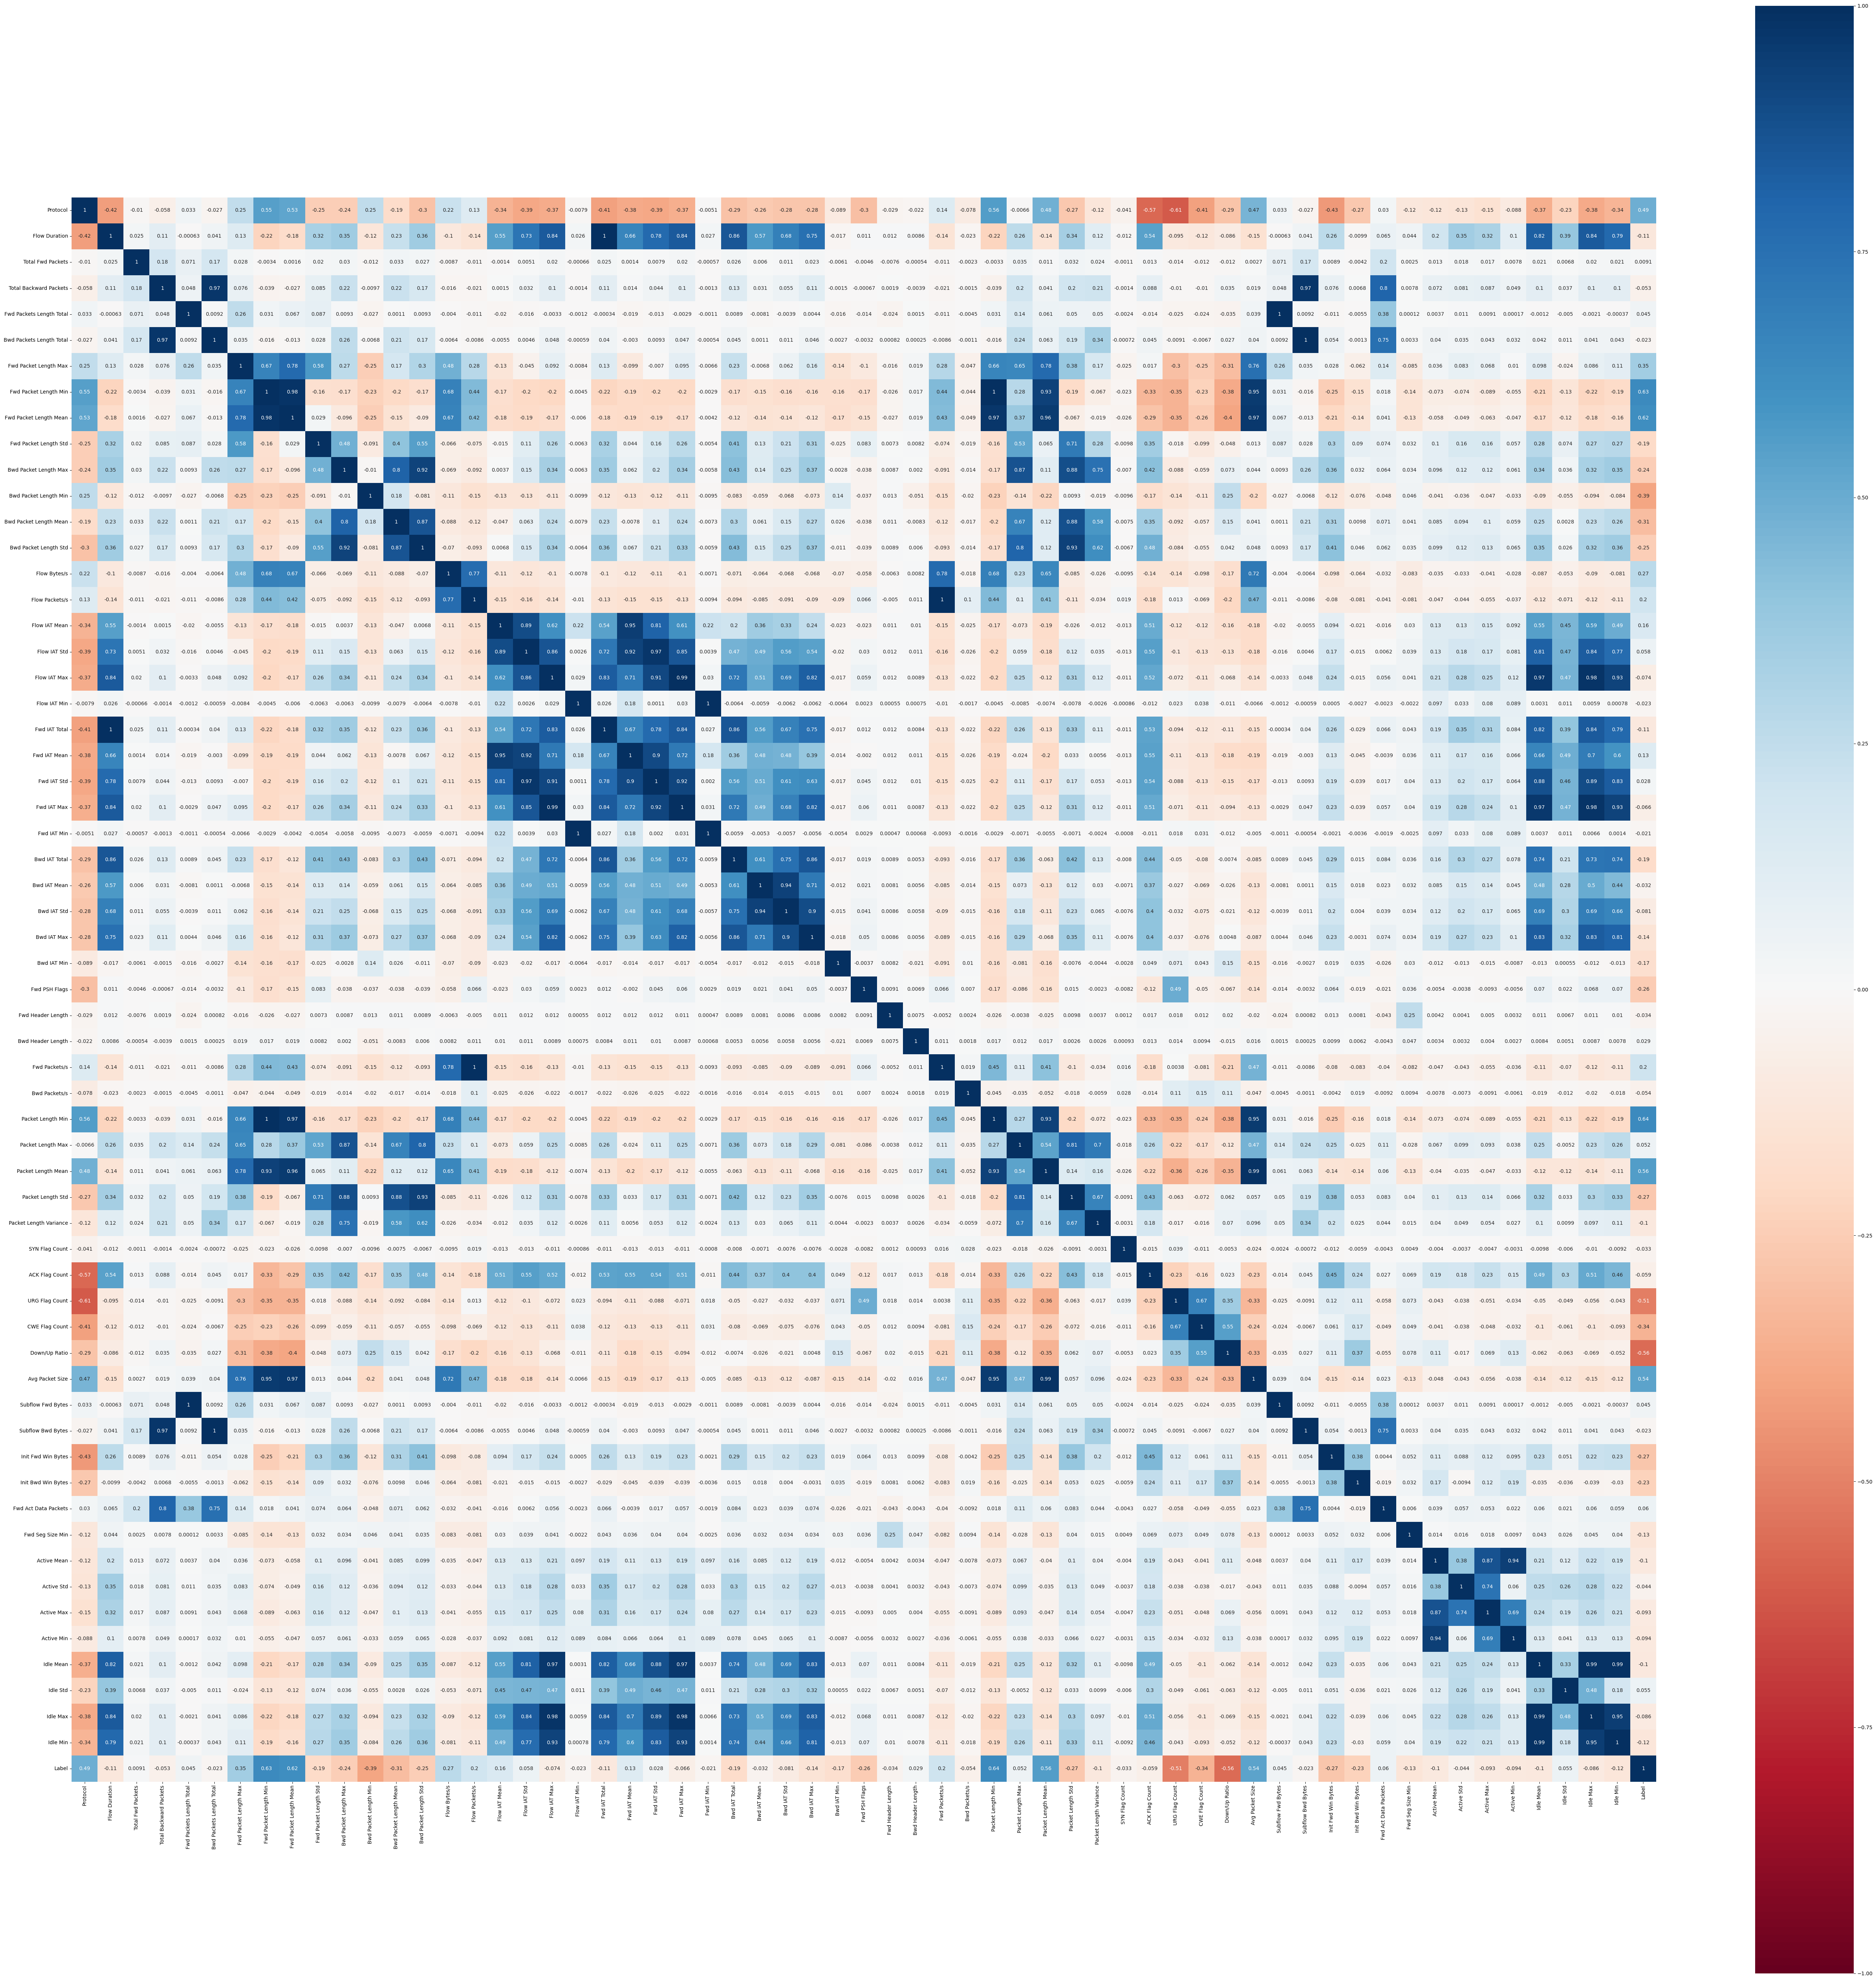

CPU times: user 6.75 s, sys: 228 ms, total: 6.98 s
Wall time: 6.91 s


In [ ]:
%%time
# pearson correlation heatmap
plt.figure(figsize=(70, 70))
corr = df_balanced.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='RdBu', vmin=-1, vmax=1, square=True) # annot=True
plt.show()

In [ ]:
%%time
correlated_col = set()
is_correlated = [True] * len(corr.columns)
threshold = 0.90
for i in range (len(corr.columns)):
    if(is_correlated[i]):
        for j in range(i):
          if (corr.iloc[i, j] >= threshold) and (is_correlated[j]):
            colname = corr.columns[j]
            is_correlated[j]=False
            correlated_col.add(colname)

print(correlated_col)
print(len(correlated_col))

{'Flow IAT Max', 'Packet Length Min', 'Fwd Packet Length Min', 'Bwd Packets Length Total', 'Fwd IAT Max', 'Fwd Packet Length Mean', 'Total Backward Packets', 'Bwd Packet Length Std', 'Flow IAT Std', 'Flow Duration', 'Active Mean', 'Flow IAT Min', 'Fwd Packets Length Total', 'Flow Packets/s', 'Fwd IAT Mean', 'Fwd IAT Std', 'Bwd IAT Mean', 'Idle Mean', 'Flow IAT Mean', 'Packet Length Mean', 'Idle Max', 'Bwd Packet Length Max'}
22
CPU times: user 22.3 ms, sys: 1e+03 µs, total: 23.3 ms
Wall time: 23.1 ms


In [ ]:
%%time
df_balanced.drop(correlated_col, axis=1, inplace=True)
print (df_balanced.shape)

(203508, 39)
CPU times: user 7.77 ms, sys: 1 ms, total: 8.78 ms
Wall time: 7.92 ms


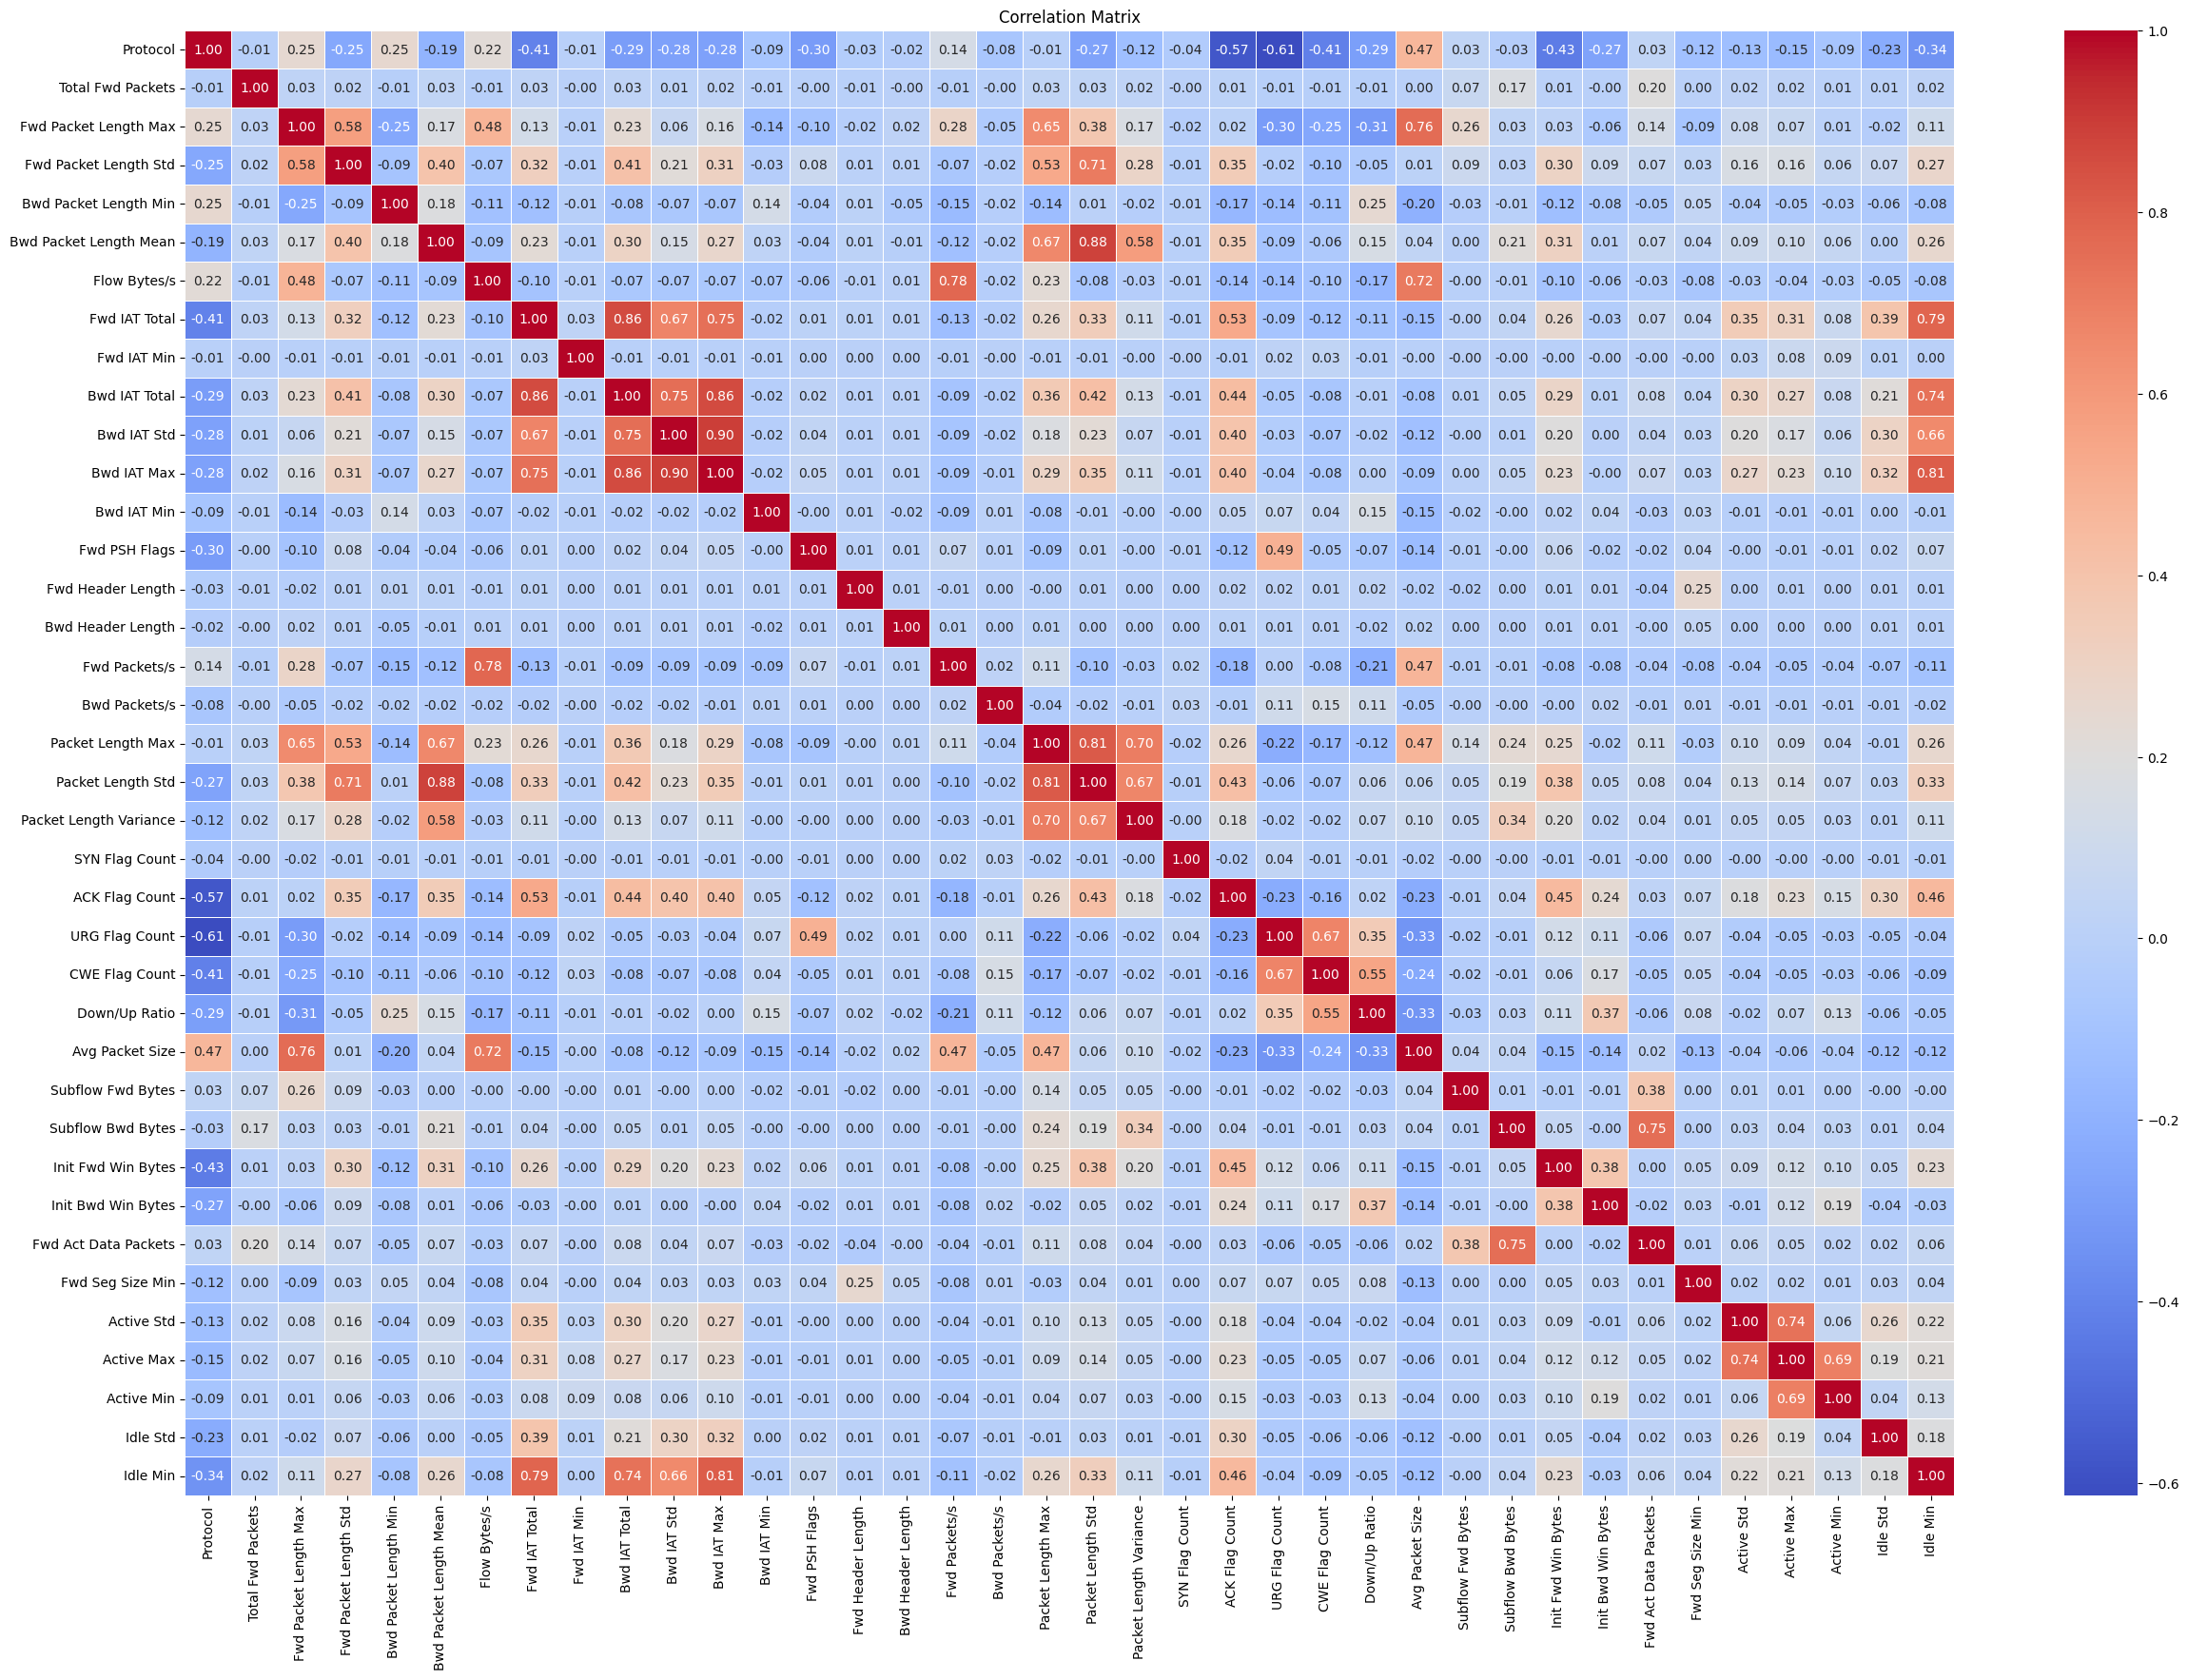

In [ ]:
# Calculate correlation matrix
correlation_matrix = df_balanced.drop('Label', axis=1).corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(30, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

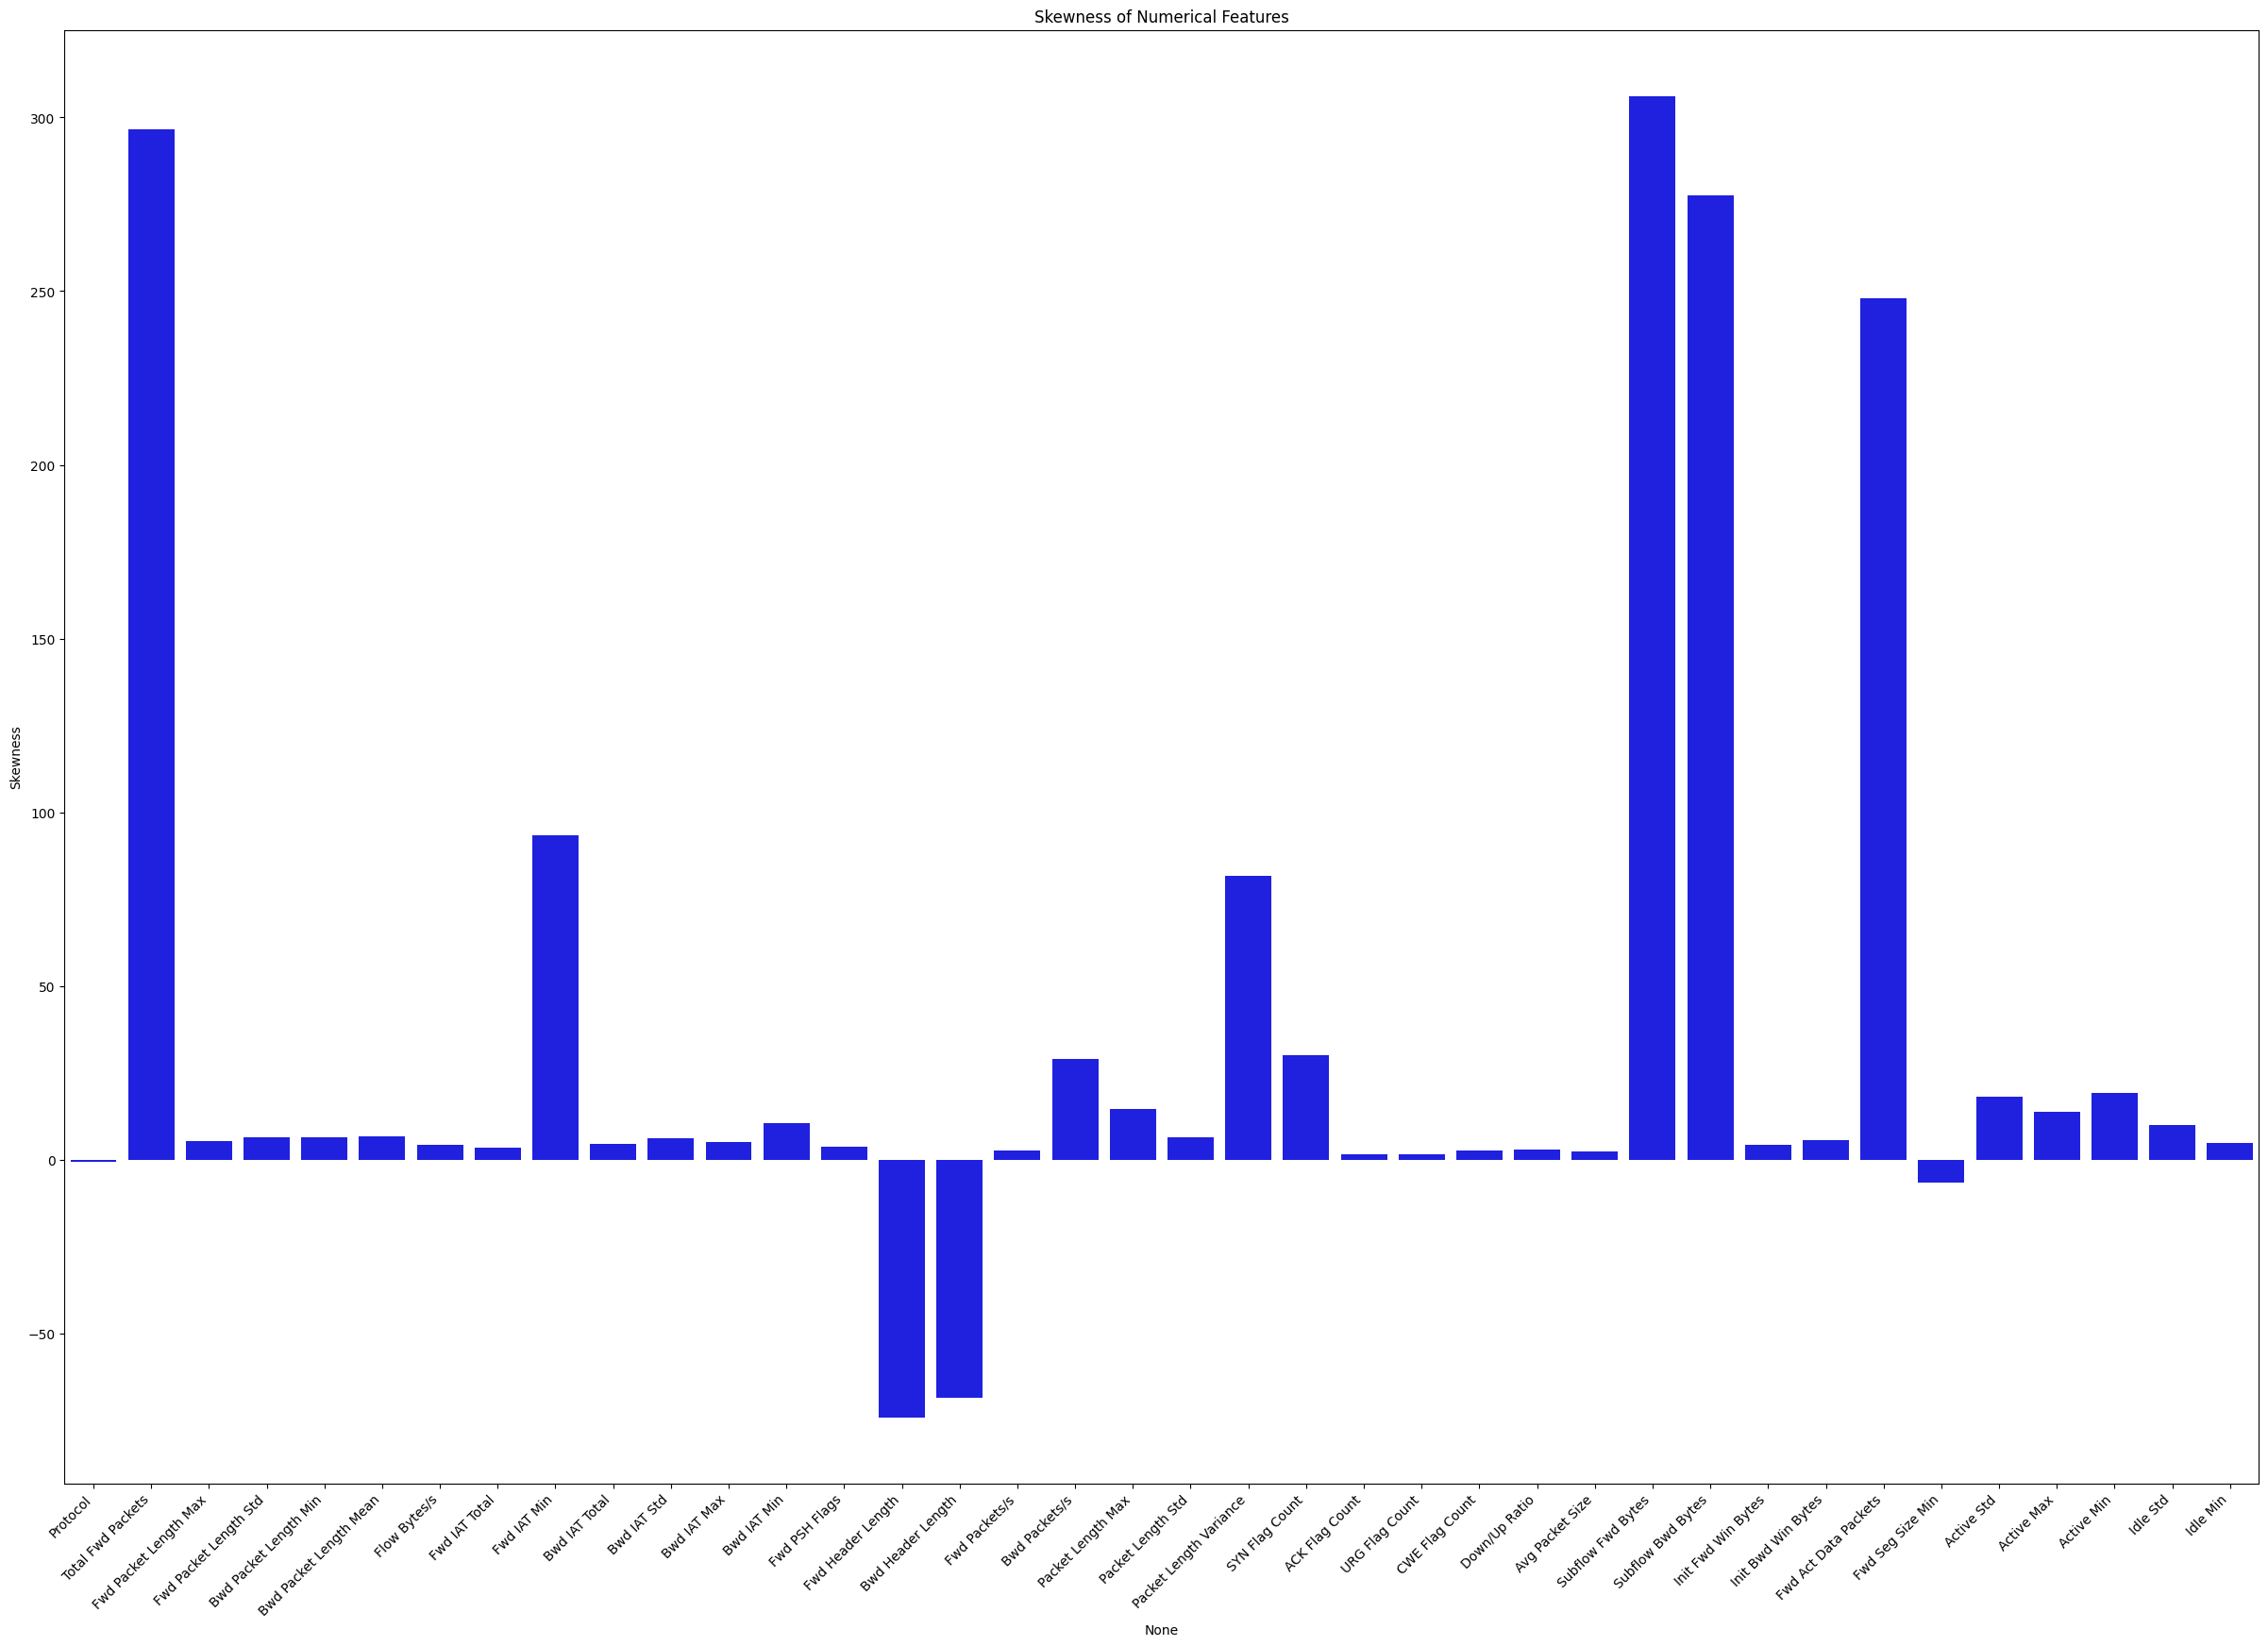

In [ ]:
# Calculate skewness for each numerical column
skewness = df_balanced.drop('Label', axis=1).skew()

# Create a bar plot or a histogram of skewness values
plt.figure(figsize=(30, 20))
sns.barplot(x=skewness.index, y=skewness.values, color='blue')
plt.xticks(rotation=45, ha='right')
plt.title('Skewness of Numerical Features')
plt.ylabel('Skewness')
plt.show()

In [ ]:
%%time
X=df_balanced.drop(["Label"], axis=1)
y=df_balanced["Label"]

# split the data for evaluation
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state =42, shuffle=True)

CPU times: user 46.4 ms, sys: 995 µs, total: 47.4 ms
Wall time: 46.5 ms


In [ ]:
x_train

Protocol  Total Fwd Packets  Fwd Packet Length Max  \
240911        17                114                  440.0   
19518         17                  6                  393.0   
425575        17                  4                  516.0   
143077        17                  2                 1257.0   
130612         6                  4                   46.0   
...          ...                ...                    ...   
126924        17                  2                 1272.0   
105201         6                  1                    6.0   
138977        17                  2                  925.0   
275280         6                  1                    0.0   
129003         6                 57                 3174.0   

        Fwd Packet Length Std  Bwd Packet Length Min  Bwd Packet Length Mean  \
240911               0.000000                    0.0                 0.00000   
19518               35.088459                    0.0                 0.00000   
425575               0.000000                    0.0                 0.00000   
143077               0.000000                    0.0                 0.00000   
130612              26.558113                    0.0                23.00000   
...                       ...                    ...                     ...   
126924               0.000000                    0.0                 0.00000   
105201               0.000000                    6.0                 6.00000   
138977               0.000000                    0.0                 0.00000   
275280               0.000000                    0.0                 0.00000   
129003             991.459961                    0.0               180.69841   

        Flow Bytes/s  Fwd IAT Total  Fwd IAT Min  Bwd IAT Total  ...  \
240911  4.549660e+06        11025.0          0.0            0.0  ...   
19518   9.826807e+03       212480.0          0.0            0.0  ...   
425575  6.888323e+02      2996375.0          1.0            0.0  ...   
143077  2.514000e+09            1.0          1.0            0.0  ...   
130612  2.365951e+03        77770.0          1.0            5.0  ...   
...              ...            ...          ...            ...  ...   
126924  2.544000e+09            1.0          1.0            0.0  ...   
105201  9.424084e+04            0.0          0.0            2.0  ...   
138977  9.250000e+08            2.0          2.0            0.0  ...   
275280  0.000000e+00            0.0          0.0            0.0  ...   
129003  4.246734e+02    110384096.0          0.0    110384032.0  ...   

        Subflow Bwd Bytes  Init Fwd Win Bytes  Init Bwd Win Bytes  \
240911                  0                  -1                  -1   
19518                   0                  -1                  -1   
425575                  0                  -1                  -1   
143077                  0                  -1                  -1   
130612                 92                 258                 311   
...                   ...                 ...                 ...   
126924                  0                  -1                  -1   
105201                 12                 246               16421   
138977                  0                  -1                  -1   
275280                  0                 253                 245   
129003              11384                8192                 556   

        Fwd Act Data Packets  Fwd Seg Size Min   Active Std  Active Max  \
240911                   113                20        0.000         0.0   
19518                      5                20        0.000         0.0   
425575                     3                -1        0.000         0.0   
143077                     1                 0        0.000         0.0   
130612                     1                20        0.000         0.0   
...                      ...               ...          ...         ...   
126924                     1              1480        0.000         0.0   
105201  

In [ ]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training set
x_train = scaler.fit_transform(x_train)

# Transform the testing set using the same scaler
x_test = scaler.transform(x_test)

In [ ]:
# Random Forest with GridSearchCV
rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
rf_model = RandomForestClassifier()
rf_grid = GridSearchCV(rf_model, rf_params, cv=3, scoring='accuracy')
rf_grid.fit(x_train, y_train)
rf_best_model = rf_grid.best_estimator_

In [ ]:
print("\nBest Estimator's Hyperparameters:")
print(rf_best_model.get_params())


Best Estimator's Hyperparameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [ ]:
# XGBoost with GridSearchCV
xgb_params = {'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}
xgb_model = XGBClassifier()

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode the target variable
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=3, scoring='accuracy')
xgb_grid.fit(x_train, y_train_encoded)
xgb_best_model = xgb_grid.best_estimator_

In [ ]:
print("\nBest Estimator's Hyperparameters:")
print(xgb_best_model.get_params())


Best Estimator's Hyperparameters:
{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.2, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 7, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


# **Calculate the Metrics for Random Forest**

In [ ]:
# Make predictions on the test set using the best Random Forest model
y_pred_rf = rf_best_model.predict(x_test)
y_proba_rf = rf_best_model.predict_proba(x_test)[:, 1] # Get probabilities for the positive class (class 1)

In [ ]:
# Calculate and print the confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix for Random Forest:")
print(conf_matrix_rf)

Confusion Matrix for Random Forest:
[[19575    14]
 [   16 21097]]


In [ ]:
print("ROC AUC Score:")
print(roc_auc_score(y_test, y_proba_rf))

ROC AUC Score:
0.9999454244391646



Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19589
           1       1.00      1.00      1.00     21113

    accuracy                           1.00     40702
   macro avg       1.00      1.00      1.00     40702
weighted avg       1.00      1.00      1.00     40702



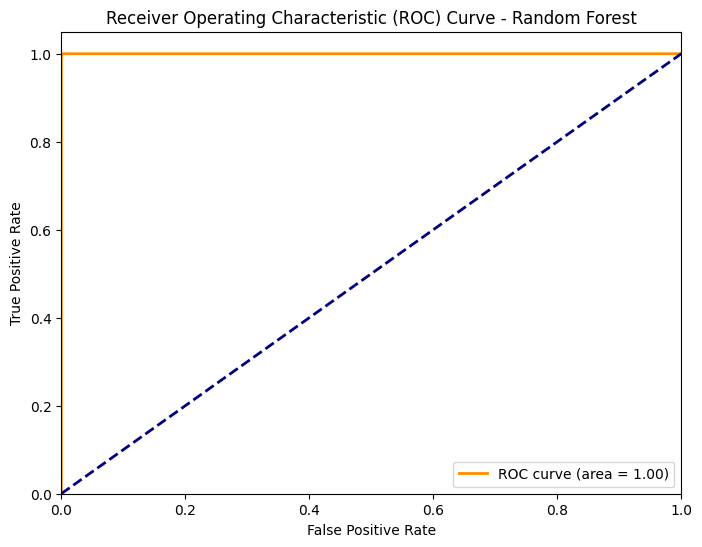

In [ ]:
# Calculate and print the classification report
class_report_rf = classification_report(y_test, y_pred_rf)
print("\nClassification Report for Random Forest:")
print(class_report_rf)

# Calculate the ROC curve and AUC
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()

# **Calculate the Metrics for XGBoost**

In [ ]:
# Make predictions on the test set using the best Random Forest model
y_pred_xgb = xgb_best_model.predict(x_test)
y_proba_xgb = xgb_best_model.predict_proba(x_test)[:, 1] # Get probabilities for the positive class (class 1)

In [ ]:
# Calculate and print the confusion matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix for XGBoost:")
print(conf_matrix_xgb)

Confusion Matrix for XGBoost:
[[19579    10]
 [   10 21103]]


In [ ]:
print("ROC AUC Score:")
print(roc_auc_score(y_test, y_proba_xgb))

ROC AUC Score:
0.9999978831312268



Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19589
           1       1.00      1.00      1.00     21113

    accuracy                           1.00     40702
   macro avg       1.00      1.00      1.00     40702
weighted avg       1.00      1.00      1.00     40702



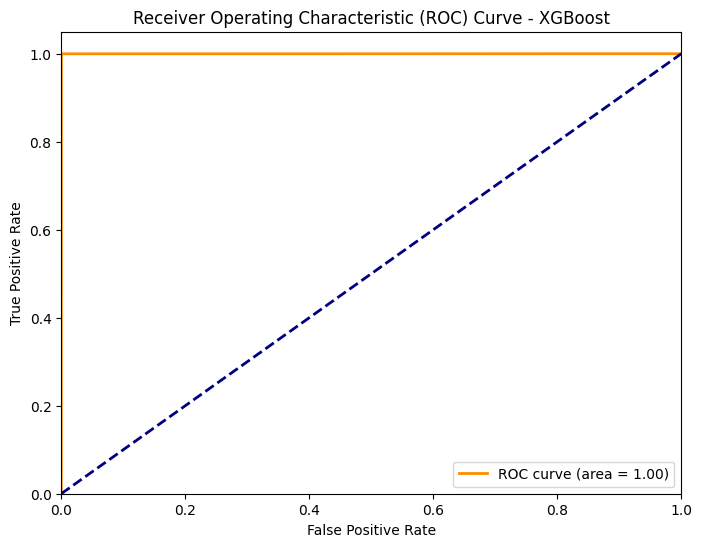

In [ ]:
# Calculate and print the classification report
class_report_xgb = classification_report(y_test, y_pred_xgb)
print("\nClassification Report for XGBoost:")
print(class_report_xgb)

# Calculate the ROC curve and AUC
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - XGBoost')
plt.legend(loc="lower right")
plt.show()

# **Explainable AI**

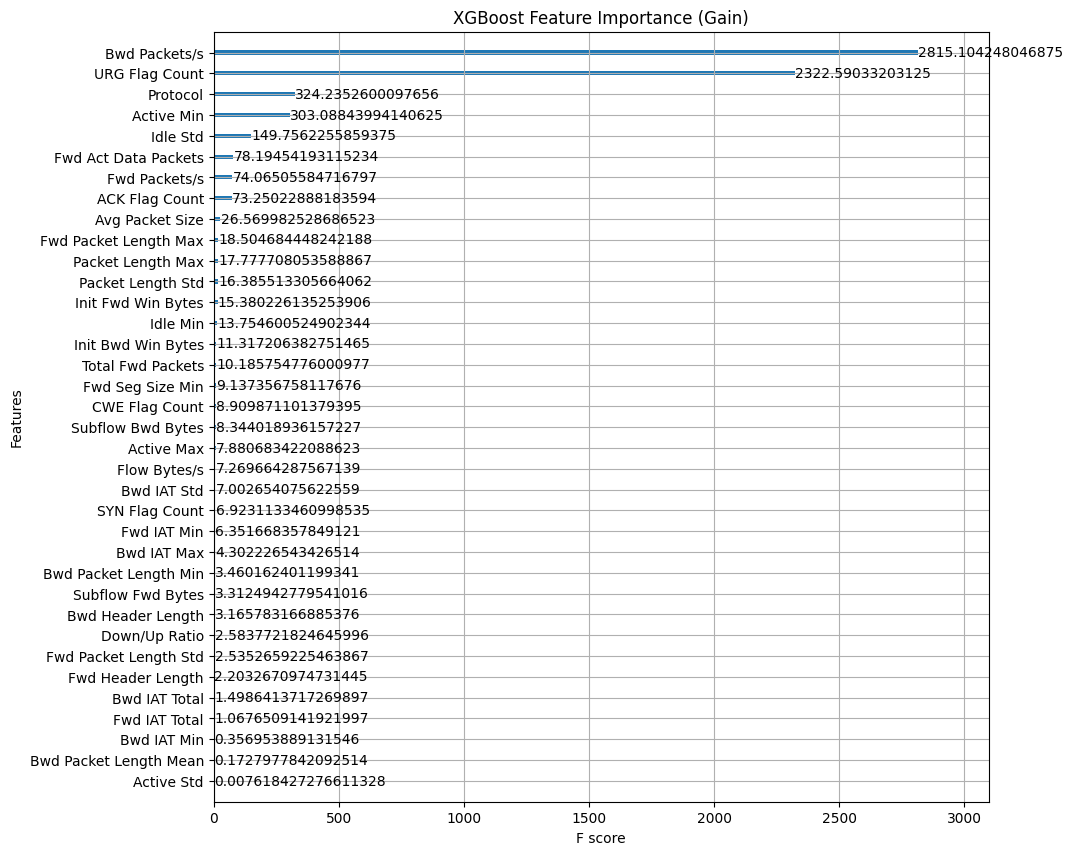

In [ ]:
# Plot the feature importance for the best XGBoost model
# You can choose the importance type: 'weight', 'gain', 'cover', 'total_gain', 'total_cover'
# 'gain' is generally recommended as it represents the average gain of splits that use the feature
#ax = xgb_best_model.get_booster().plot_importance(importance_type='gain')
import xgboost as xgb
# Get the feature names from the original DataFrame before splitting
feature_names = df_balanced.columns
ax = xgb.plot_importance(xgb_best_model.get_booster(), importance_type='gain')

# Manually set the y-tick labels to the actual feature names
# The y-ticks correspond to the sorted feature importances, so we need to get the features in that order
sorted_importance = xgb_best_model.get_booster().get_score(importance_type='gain')
sorted_features = sorted(sorted_importance, key=sorted_importance.get)
ax.set_yticklabels([feature_names[int(f.replace('f', ''))] for f in sorted_features])

# Set the figure size for better visualization
fig = ax.figure
fig.set_size_inches(10, 10)

# Set a title
ax.set_title("XGBoost Feature Importance (Gain)")

plt.show()